In [195]:
import polars as pl
import cmdstanpy as stan
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

In [196]:
df_freq = pl.read_csv("./data/insurance/freMTPL2freq.csv")

df_sev = (
    pl.read_csv("./data/insurance/freMTPL2sev.csv", infer_schema_length=25000)
    .group_by("IDpol")
    .sum()
)

df = df_freq.join(df_sev, on="IDpol", how="left", coalesce=True).with_columns(
    pl.col("ClaimAmount").fill_null(0)
)

In [197]:
df_sample = df.sample(5000, seed=42)

In [198]:
model = stan.CmdStanModel(stan_file="./models/insurance_resampling.stan")

16:24:24 - cmdstanpy - INFO - compiling stan file /Users/erikdains/Programming/PythonBlogProjects/models/insurance_resampling.stan to exe file /Users/erikdains/Programming/PythonBlogProjects/models/insurance_resampling
16:24:29 - cmdstanpy - INFO - compiled model executable: /Users/erikdains/Programming/PythonBlogProjects/models/insurance_resampling


In [199]:
data = {
    "N": len(df_sample),
    "E": df_sample["Exposure"].to_list(),
    "C": df_sample["ClaimNb"].to_list(),
    "S": df_sample["ClaimAmount"].to_list(),
}

fit = model.sample(data=data)

16:24:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:10 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:11 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:13 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:14 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:16 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:17 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:18 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:20 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:21 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:22 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:25 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:27 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:29 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chai


16:25:15 - cmdstanpy - INFO - CmdStan done processing.
16:25:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: exponential_lpdf: Inverse scale parameter is 0, but must be positive finite! (in 'insurance_resampling.stan', line 15, column 4 to column 30)
	Exception: exponential_lpdf: Inverse scale parameter is 0, but must be positive finite! (in 'insurance_resampling.stan', line 15, column 4 to column 30)
	Exception: exponential_lpdf: Inverse scale parameter is 0, but must be positive finite! (in 'insurance_resampling.stan', line 15, column 4 to column 30)
	Exception: exponential_lpdf: Inverse scale parameter is 0, but must be positive finite! (in 'insurance_resampling.stan', line 15, column 4 to column 30)
	Exception: exponential_lpdf: Inverse scale parameter is 0, but must be positive finite! (in 'insurance_resampling.stan', line 15, column 4 to column 30)
	Exception: exponential_lpdf: Inverse scale parameter is 0, but must be positive finite! (in 'insurance_resam

In [200]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  omega
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating your model with additional prior information or a more effective parameterization.

Processing complete.



In [201]:
idata = az.from_cmdstanpy(
    fit, posterior_predictive=["C_hat", "S_hat"], observed_data=data
)

array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'omega'}>,
        <Axes: title={'center': 'omega'}>]], dtype=object)

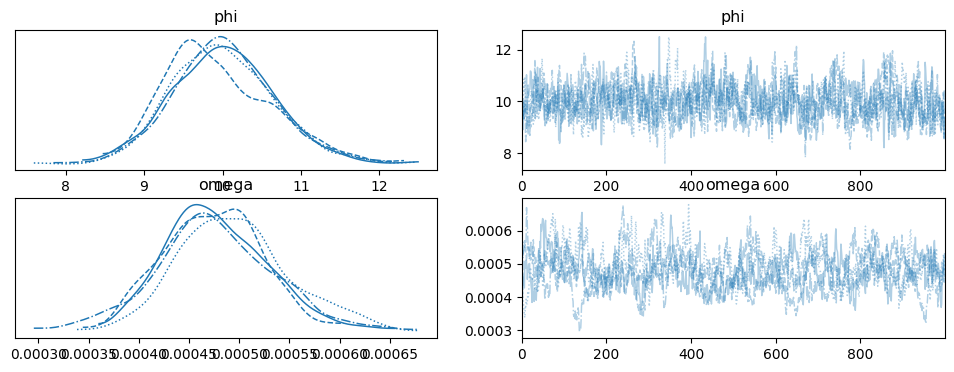

In [202]:
az.plot_trace(idata, var_names=["phi", "omega"])

In [203]:
np.corrcoef(df_sample["Exposure"], az.extract(idata, var_names=["lambda"]).var(axis=1))

array([[ 1.        , -0.22456326],
       [-0.22456326,  1.        ]])

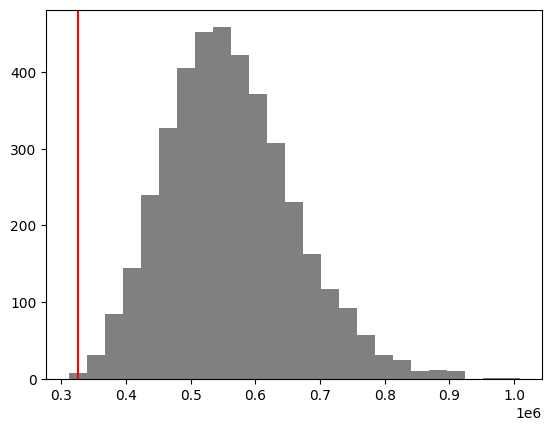

In [204]:
plt.hist(
    az.extract(idata.posterior_predictive, var_names=["S_hat"]).sum(axis=0),
    bins=25,
    color="grey",
)
plt.axvline(df_sample["ClaimAmount"].sum(), color="red")

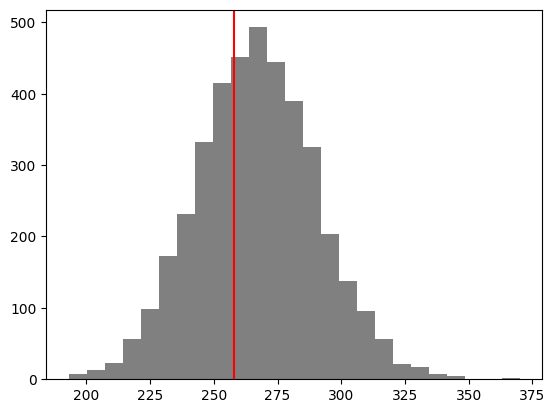

In [205]:
plt.hist(
    az.extract(idata.posterior_predictive, var_names=["C_hat"]).sum(axis=0),
    bins=25,
    color="grey",
)
plt.axvline(df_sample["ClaimNb"].sum(), color="red")

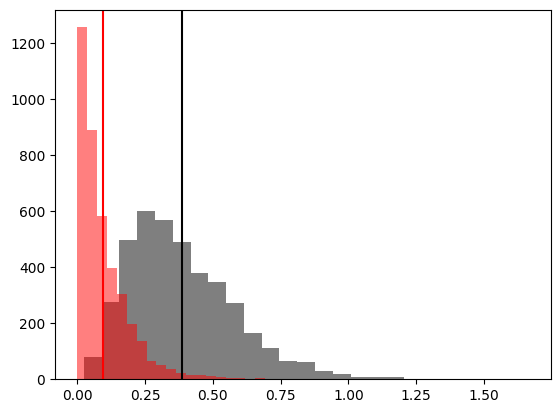

In [206]:
lam_sample = az.extract(idata, var_names="lambda")
high_claim = lam_sample[df_sample["ClaimNb"].to_numpy().argmax()]
low_claim = lam_sample[df_sample["ClaimNb"].to_numpy().argmin()]

plt.hist(high_claim, bins=25, alpha=0.5, color="black")
plt.hist(low_claim, bins=25, alpha=0.5, color="red")
plt.axvline(high_claim.mean(), color="black")
plt.axvline(low_claim.mean(), color="red")

In [207]:
def plot_hierarchical_shrinkage(
    raw_values, posterior_means, weights, x_label, y_label, title, outlier_percentile=95
):
    """
    Creates a plot showing hierarchical shrinkage effects.

    Parameters:
    -----------
    raw_values : numpy.ndarray
        Raw (MLE) parameter estimates
    posterior_means : numpy.ndarray
        Posterior means from hierarchical model
    weights : numpy.ndarray
        Values to determine point sizes (e.g., exposures or claim counts)
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    title : str
        Plot title
    outlier_percentile : float
        Percentile threshold for outlier removal (default: 95)
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Get the global mean
    global_mean = posterior_means.mean()

    # Split zero and positive values
    zero_mask = raw_values == 0
    zero_posterior = posterior_means[zero_mask]

    pos_mask = raw_values > 0
    pos_raw = raw_values[pos_mask]
    pos_posterior = posterior_means[pos_mask]
    pos_weights = weights[pos_mask]

    # Remove outliers from positive values
    outlier_threshold = np.percentile(pos_raw, outlier_percentile)
    sub_mask = pos_raw < outlier_threshold
    pos_raw = pos_raw[sub_mask]
    pos_posterior = pos_posterior[sub_mask]
    pos_weights = pos_weights[sub_mask]

    # Aggregate zero values
    zero_mean_posterior = zero_posterior.mean() if len(zero_posterior) > 0 else 0

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot positive values
    plt.scatter(
        pos_raw, pos_posterior, s=pos_weights * 100, alpha=0.7, label="Positive Values"
    )

    # Plot aggregated zero value point if it exists
    if len(zero_posterior) > 0:
        plt.scatter(
            0,
            zero_mean_posterior,
            s=100,
            alpha=0.7,
            color="orange",
            label="Aggregated Zero Values",
        )

    # Plot the global mean line
    plt.axhline(
        y=global_mean,
        color="r",
        linestyle="-",
        alpha=0.5,
        label=f"Global Mean ({global_mean:.4f})",
    )

    # Connect points to the global mean with lines to show shrinkage
    for i in range(len(pos_raw)):
        plt.plot(
            [pos_raw[i], pos_raw[i]], [pos_posterior[i], global_mean], "g-", alpha=0.3
        )

    # Connect aggregated zero point to global mean if it exists
    if len(zero_posterior) > 0:
        plt.plot([0, 0], [zero_mean_posterior, global_mean], "g-", alpha=0.7)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt

<module 'matplotlib.pyplot' from '/Users/erikdains/Programming/PythonBlogProjects/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

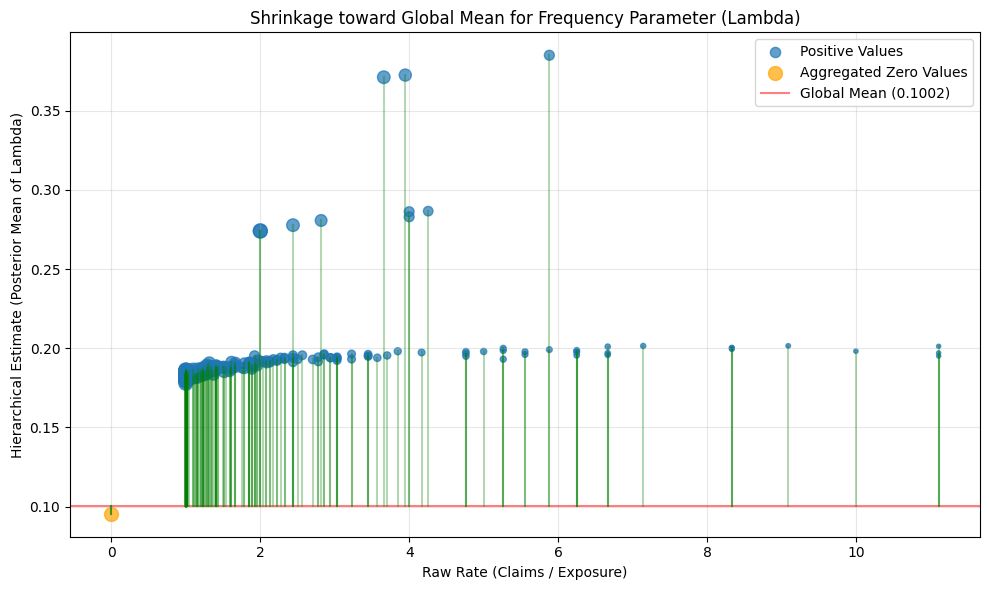

In [208]:
exposures = np.array(idata.observed_data["E"])
raw_rates = np.array(idata.observed_data["C"]) / exposures
lambda_means = idata.posterior["lambda"].values.mean(axis=(0, 1))

plot_hierarchical_shrinkage(
    raw_rates,
    lambda_means,
    exposures,
    "Raw Rate (Claims / Exposure)",
    "Hierarchical Estimate (Posterior Mean of Lambda)",
    "Shrinkage toward Global Mean for Frequency Parameter (Lambda)",
)

<module 'matplotlib.pyplot' from '/Users/erikdains/Programming/PythonBlogProjects/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

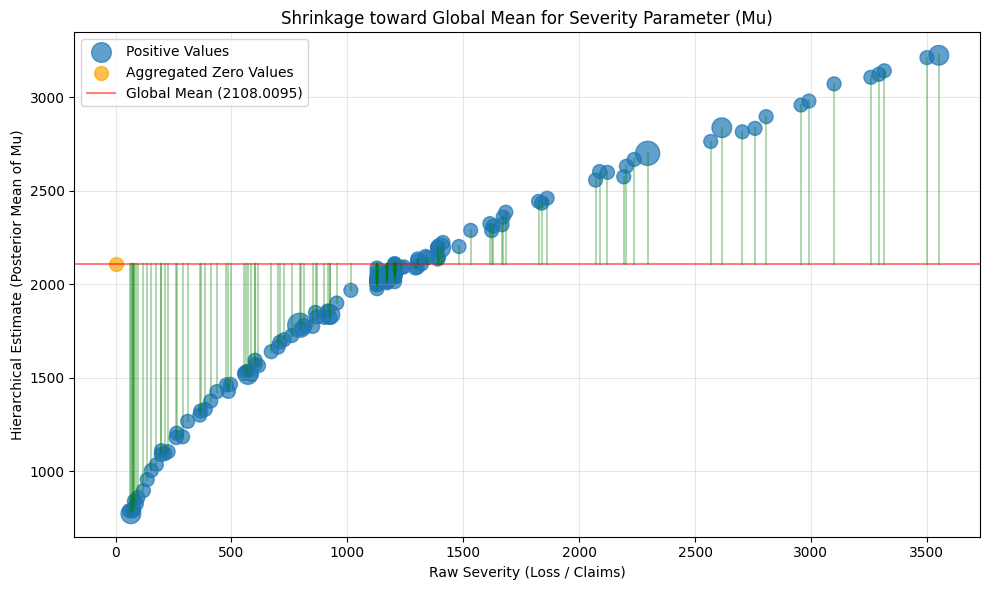

In [209]:
loss_amounts = np.array(idata.observed_data["S"])
claim_counts = np.array(idata.observed_data["C"])

pos_claim_mask = claim_counts > 0
raw_severity = np.zeros_like(loss_amounts)
raw_severity[pos_claim_mask] = (
    loss_amounts[pos_claim_mask] / claim_counts[pos_claim_mask]
)

mu_means = idata.posterior["mu"].values.mean(axis=(0, 1))

plot_hierarchical_shrinkage(
    raw_severity,
    mu_means,
    claim_counts,
    "Raw Severity (Loss / Claims)",
    "Hierarchical Estimate (Posterior Mean of Mu)",
    "Shrinkage toward Global Mean for Severity Parameter (Mu)",
)

In [210]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X = df.drop(["IDpol", "ClaimNb", "ClaimAmount"]).to_pandas()
y = df["ClaimNb"].to_pandas()

cat_features = ["Area", "VehBrand", "VehGas", "Region"]

for feature in cat_features:
    X[feature] = X[feature].astype("category")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [267]:
params = {
    "objective": "count:poisson",
    "eta": 0.05,
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dval, "validation")],
    early_stopping_rounds=20,
    verbose_eval=100,
)


[0]	train-poisson-nloglik:0.21107	validation-poisson-nloglik:0.21146
[100]	train-poisson-nloglik:0.19588	validation-poisson-nloglik:0.19844
[200]	train-poisson-nloglik:0.19333	validation-poisson-nloglik:0.19751
[300]	train-poisson-nloglik:0.19191	validation-poisson-nloglik:0.19715
[400]	train-poisson-nloglik:0.19098	validation-poisson-nloglik:0.19701
[500]	train-poisson-nloglik:0.19003	validation-poisson-nloglik:0.19691
[600]	train-poisson-nloglik:0.18898	validation-poisson-nloglik:0.19682
[683]	train-poisson-nloglik:0.18810	validation-poisson-nloglik:0.19678


In [268]:
df_sample_predict = df_sample.drop(["IDpol", "ClaimNb", "ClaimAmount"]).to_pandas()

for feature in cat_features:
    df_sample_predict[feature] = df_sample_predict[feature].astype("category")

predictions = model.predict(xgb.DMatrix(df_sample_predict, enable_categorical=True))
sample_freq = az.extract(idata, var_names=["lambda"])

In [269]:
qs = np.linspace(1 / 5, 1, 4, endpoint=False)
quantiles = np.quantile(predictions, qs)
exposures = df_sample["Exposure"].to_numpy()
results = {}

for idx in range(len(quantiles) + 1):
    subset_idx = np.searchsorted(quantiles, predictions) == idx
    freq_subset = sample_freq[subset_idx, :]
    exposures_subset = exposures[subset_idx]
    predictions_subset = predictions[subset_idx]

    results[idx] = {
        "predicted": predictions_subset.sum(),
        "q5": (np.quantile(freq_subset, 0.05, axis=1) * exposures_subset).sum(),
        "median": (np.quantile(freq_subset, 0.50, axis=1) * exposures_subset).sum(),
        "q95": (np.quantile(freq_subset, 0.95, axis=1) * exposures_subset).sum(),
    }

In [270]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches


def plot_quantiles_with_predictions(data_dict):
    fig, ax = plt.subplots(figsize=(10, 6))

    bins = sorted(list(data_dict.keys()))
    x_positions = np.arange(len(bins))

    # Extract data for plotting
    medians = [data_dict[bin_idx]["median"] for bin_idx in bins]
    q5s = [data_dict[bin_idx]["q5"] for bin_idx in bins]
    q95s = [data_dict[bin_idx]["q95"] for bin_idx in bins]
    predictions = [data_dict[bin_idx]["predicted"] for bin_idx in bins]

    # Plot quantile ranges
    ax.vlines(x_positions, q5s, q95s, color="cornflowerblue", alpha=0.7, linewidth=3)

    # Plot median markers
    median_dots = ax.scatter(
        x_positions, medians, color="navy", s=80, zorder=3, label="Median"
    )

    # Plot predictions
    pred_dots = ax.scatter(
        x_positions,
        predictions,
        color="crimson",
        marker="X",
        s=100,
        zorder=3,
        label="Predicted",
    )

    # Add bin labels to x-axis
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"Bin {bin_idx}" for bin_idx in bins])

    # Set labels and title
    ax.set_xlabel("Bin", fontsize=12)
    ax.set_ylabel("Total Claims", fontsize=12)
    ax.set_title("Predicted Values vs. Quantile Ranges by Bin", fontsize=14)

    # Add legend elements
    q_patch = mpatches.Patch(
        color="cornflowerblue", alpha=0.7, label="5th-95th Percentile Range"
    )

    # Create legend with all elements
    ax.legend(handles=[q_patch, median_dots, pred_dots], loc="upper left")

    # Grid and style
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.set_axisbelow(True)
    plt.tight_layout()

    return fig

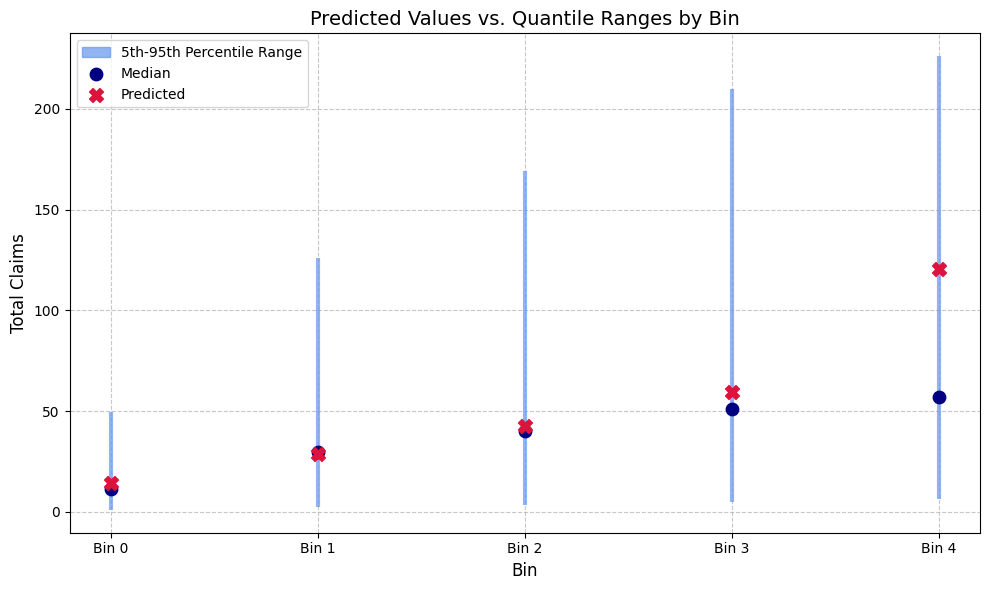

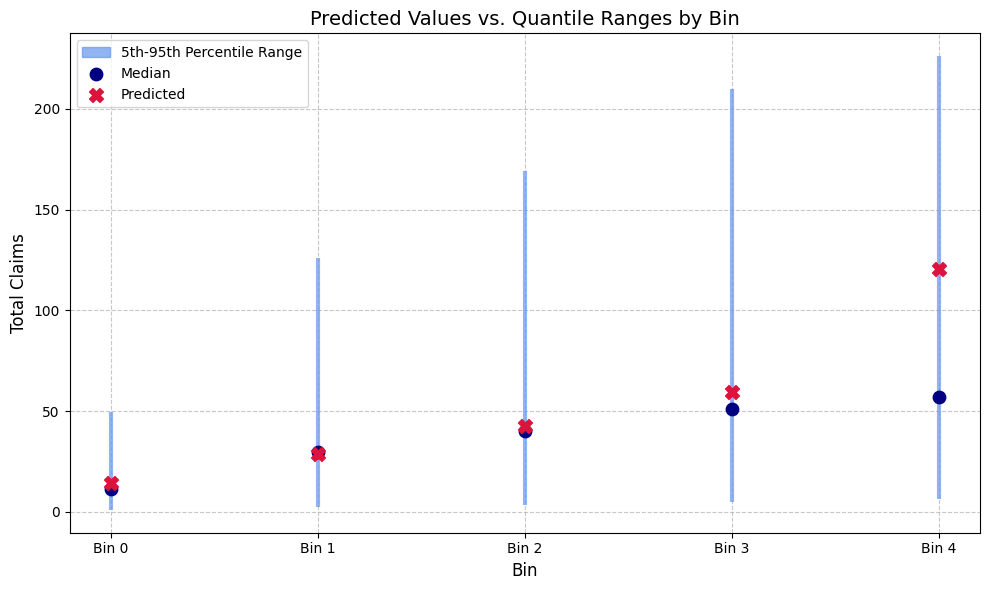

In [271]:
plot_quantiles_with_predictions(results)